# 分類模型的評估

## 學習資料集

## 混淆矩陣 (confusion Matrix)

- 第一象限: FP (Type I error)
- 第二象限: TP
- 第三象限: FN (Type II error)
- 第四象限: TN

**Accuracy  = (TP+TN) / (TP+TN+FP+FN)**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

In [2]:
%%time
#1. 手刻 ，計算 Accuracy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/Titanic-Machine-Learning-from-Disaster/train.csv")
# Removed observations without Age
labeled = labeled[~labeled["Age"].isna()]
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
X_train = train.loc[:, ["Age", "Fare"]].values
y_train = train.loc[:, "Survived"].values
# Fit Logistic regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)
X_validation = validation.loc[:, ["Age", "Fare"]].values
y_validation = validation.loc[:, "Survived"].values
y_hat = clf.predict(X_validation)
# Calculating confusion matrix
nunique_labels = len(set(y_train))
conf_mat_shape = (nunique_labels, nunique_labels)
conf_mat = np.zeros(conf_mat_shape, dtype=int)
for actual, predict in zip(y_hat, y_validation):
  conf_mat[actual, predict] += 1
# Calculating accuracy
accuracy = (conf_mat[0, 0] + conf_mat[1, 1])/conf_mat.sum()
print(conf_mat)
print("Accuracy: {:.2f}%".format(accuracy*100))

[[121  63]
 [ 10  21]]
Accuracy: 66.05%
Wall time: 1.17 s


可以使用sklearn.metrics 中的 confusion.matrix() 與 accuracy_score()  

In [3]:
%%time
#2. 運用套件，計算 Accuracy

from sklearn.metrics import confusion_matrix, accuracy_score

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/Titanic-Machine-Learning-from-Disaster/train.csv")
# Removed observations without Age
labeled = labeled[~labeled["Age"].isna()]
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
X_train = train.loc[:, ["Age", "Fare"]].values
y_train = train.loc[:, "Survived"].values
# Fit Logistic regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)
X_validation = validation.loc[:, ["Age", "Fare"]].values
y_validation = validation.loc[:, "Survived"].values
y_hat = clf.predict(X_validation)
# Calculating confusion matrix
conf_mat = confusion_matrix(y_validation, y_hat)
# Calculating accuracy
accuracy = accuracy_score(y_validation, y_hat)
print(conf_mat)
print("Accuracy: {:.2f}%".format(accuracy*100))

[[121  10]
 [ 63  21]]
Accuracy: 66.05%
Wall time: 135 ms


## 建立非線性決策邊界
若直線的決策邊界無法有效將兩類分隔，則可使用非線性  
  
可以引用 skleran.preprocessing 中的 PolynomialFeatures() 將高次項加入訓練資料中  

In [4]:

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import PolynomialFeatures

def plot_decision_boundary(xlab, ylab, clf, labeled, pos_label="Survived", neg_label="Dead", clf_target="Survived", degree=1):
  xx_min, xx_max = labeled[xlab].min(), labeled[xlab].max()
  yy_min, yy_max = labeled[ylab].min(), labeled[ylab].max()
  xx_arr = np.linspace(xx_min - 5, xx_max + 5, 1000)
  yy_arr = np.linspace(yy_min - 5, yy_max + 5, 1000)
  xx, yy = np.meshgrid(xx_arr, yy_arr)
  X_grid = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
  X_grid_poly = PolynomialFeatures(degree).fit_transform(X_grid)
  Z = clf.predict(X_grid_poly).reshape(xx.shape)
  pos = labeled[labeled[clf_target] == 1]
  neg = labeled[labeled[clf_target] == 0]
  plt.scatter(pos[xlab], pos[ylab], label=pos_label, marker="o", color="blue")
  plt.scatter(neg[xlab], neg[ylab], label=neg_label, marker="x", color="red")
  plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm_r)
  plt.legend()
  plt.xlabel(xlab)
  plt.ylabel(ylab)

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/Titanic-Machine-Learning-from-Disaster/train.csv")
# Removed observations without Age
labeled = labeled[~labeled["Age"].isna()]
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
X_train = train.loc[:, ["Fare", "Age"]].values
# Polynomial features
d = 6
X_train_poly = PolynomialFeatures(d).fit_transform(X_train)
y_train = train.loc[:, "Survived"].values
# Fit Logistic regression classifier
clf = LogisticRegression()
clf.fit(X_train_poly, y_train)
# Decision boundary plot
plot_decision_boundary("Fare", "Age", clf, labeled, degree=d)
plt.show()

<Figure size 640x480 with 1 Axes>

## 正規化
建立高次項模型後，可能會造成overfitting  
通常低誤差(Low bias)、高變異(High variance)的資料易造成過擬合  
  


與迴歸模型相同，可以使用正規化來避免  
在成本函數增加一個懲罰項(penalty)  
常見的正規化模型: Ridge  

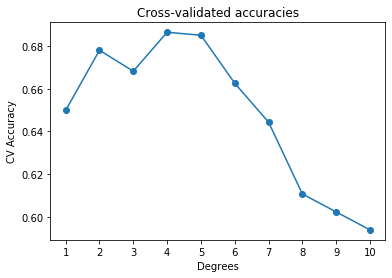

In [5]:
#1. 手刻 ，實現正規化
#從結果圖形可以看出，交叉驗證的準確率在某個高次項後開始下降
from sklearn.model_selection import cross_val_score

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/Titanic-Machine-Learning-from-Disaster/train.csv")
# Removed observations without Age
labeled = labeled[~labeled["Age"].isna()]
X = labeled.loc[:, ["Fare", "Age"]].values
y = labeled.loc[:, "Survived"].values
d = 10
poly_degrees = list(range(1, d+1))
cv_accuracies = []
for poly_d in poly_degrees:
  X_poly = PolynomialFeatures(poly_d).fit_transform(X)
  # Get cross validated train/valid accuracy
  clf = LogisticRegression()
  cv_acc = np.array(cross_val_score(clf, X_poly, y)).mean()
  cv_accuracies.append(cv_acc)

plt.plot(cv_accuracies, marker="o")
plt.xticks(range(d), poly_degrees)
plt.title("Cross-validated accuracies")
plt.xlabel("Degrees")
plt.ylabel("CV Accuracy")
plt.show()

可以使用 sklearn.linear_model 中的 RidgeClassifier()  

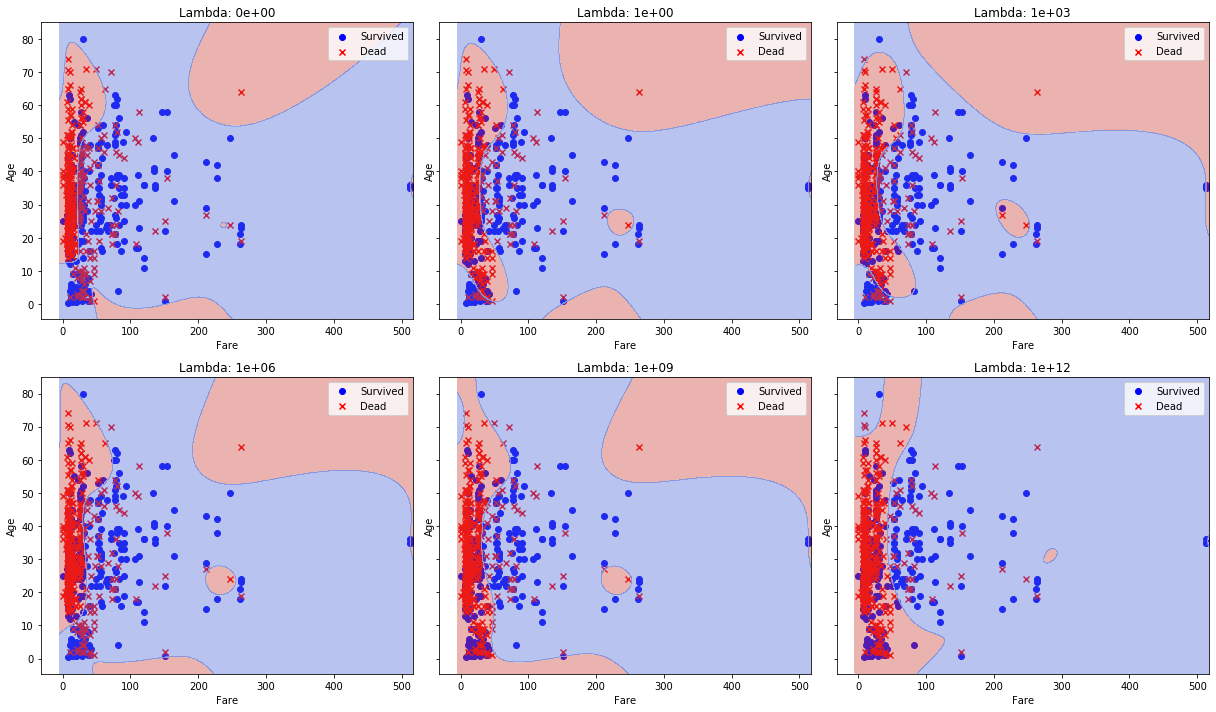

In [6]:
#2. 運用套件，實現正規化
# 調整不同lambda值並觀察
# lambda越高的情況下，即便在高次方項的設定下，決策邊界也會趨於不明顯
from sklearn.linear_model import RidgeClassifier

def sigmoid(z):
  return 1/(1 + np.exp(-z))

def step(g_y_hat, threshold=0.5):
  return np.where(g_y_hat >= threshold, 1, 0).reshape(-1, 1)

def plot_decision_boundary(xlab, ylab, thetas, labeled, pos_label="Survived", neg_label="Dead", clf_target="Survived", poly_d=6, axes=None):
  xx_min, xx_max = labeled[xlab].min(), labeled[xlab].max()
  yy_min, yy_max = labeled[ylab].min(), labeled[ylab].max()
  xx_arr = np.linspace(xx_min - 5, xx_max + 5, 1000)
  yy_arr = np.linspace(yy_min - 5, yy_max + 5, 1000)
  xx, yy = np.meshgrid(xx_arr, yy_arr)
  X_grid = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
  X_grid_poly = PolynomialFeatures(poly_d).fit_transform(X_grid)
  Z = step(sigmoid(np.dot(X_grid_poly, thetas))).reshape(xx.shape)
  pos = labeled[labeled[clf_target] == 1]
  neg = labeled[labeled[clf_target] == 0]
  if axes == None:
    axes = plt.gca()
  axes.scatter(pos[xlab], pos[ylab], label=pos_label, marker="o", color="blue")
  axes.scatter(neg[xlab], neg[ylab], label=neg_label, marker="x", color="red")
  axes.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm_r)
  axes.legend()
  axes.set_xlabel(xlab)
  axes.set_ylabel(ylab)

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/Titanic-Machine-Learning-from-Disaster/train.csv")
# Removed observations without Age
labeled = labeled[~labeled["Age"].isna()]
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
X_train = train.loc[:, ["Fare", "Age"]].values
X_train_poly = PolynomialFeatures(6).fit_transform(X_train)
y_train = train.loc[:, "Survived"].values
ridge_clf = RidgeClassifier()
ridge_clf.fit(X_train_poly, y_train)
thetas = np.concatenate([ridge_clf.intercept_.reshape(-1, 1), ridge_clf.coef_[0, 1:].reshape(-1, 1)])

# Decision boundary plots
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(17, 10))
for i, alpha in enumerate([0, 1, 1e3, 1e6, 1e9, 1e12]):
  ridge_clf = RidgeClassifier(alpha=alpha)
  ridge_clf.fit(X_train_poly, y_train)
  thetas = np.concatenate([ridge_clf.intercept_.reshape(-1, 1), ridge_clf.coef_[0, 1:].reshape(-1, 1)])
  plot_decision_boundary("Fare", "Age", thetas, labeled, axes=axes.ravel()[i])
  axes.ravel()[i].set_title("Lambda: {:.0e}".format(ridge_clf.alpha))
plt.tight_layout()

## 多元分類

In [7]:
import pandas as pd

titanic = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/Titanic-Machine-Learning-from-Disaster/train.csv")
digit_recognizer = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/Digit-Recognizer/train.csv")
unique_digits = digit_recognizer["label"].unique()
unique_digits.sort()
print("Binaray classification:")
print(titanic["Survived"].unique())
print("Multi-class classification:")
print(unique_digits)

Binaray classification:
[0 1]
Multi-class classification:
[0 1 2 3 4 5 6 7 8 9]


def cost_function_regularized(X, y, thetas, Lambda):
  m = y.size
  h = sigmoid(X.dot(thetas))
  J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + (Lambda/(2*m))*np.sum(np.square(thetas[1:]))
  if np.isnan(J):
    return np.inf
  else:
    return J
  
def get_gradient(X, y, thetas, Lambda):
  m = y.size
  h = sigmoid(X.dot(thetas))
  zero_arr = np.array([0]).reshape(-1, 1)
  regularized_thetas = np.concatenate([zero_arr, thetas])
  grad = (1/m)*X.T.dot(h-y) + (Lambda/m)*regularized_thetas
  return grad.reshape(-1, 1)

手寫數字的圖片是28*28  
可以把前100個觀察值的784個特徵重新整理為(28,28)  
並在左下角印出圖片的標籤  

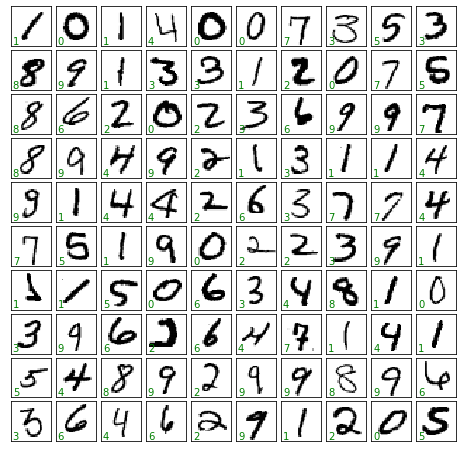

In [8]:
digit_recognizer = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/Digit-Recognizer/train.csv")
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
  digit = digit_recognizer.iloc[i, 1:].values.reshape(28, 28)
  ax.imshow(digit, cmap='binary', interpolation='nearest')
  ax.text(0.05, 0.05, str(digit_recognizer["label"][i]),
          transform=ax.transAxes, color='green')
  ax.set_xticks([])
  ax.set_yticks([])

#### 如何將處理二元分類的羅吉斯回歸用於多元分類?
**可以用 One-v.s-all 的方法**  
第一次將數字0視為分類1 ，其餘為0  
第二次將數字1視為分類1 ，其餘為0  
第三次將數字2視為分類1 ，其餘為0  
以此類推操作十個回合的二元分類  
就能得到每個觀測值被辨識為10個數字的個別數機率  
比對這些機率，以最高者作為預測

*One-v.s-all已經內建在羅吉斯函數中，可以直接運用*  


In [9]:
digits = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/Digit-Recognizer/train.csv")
unique_digits = digits["label"].unique()
unique_digits.sort()
train, validation = train_test_split(digits, test_size=0.3, random_state=123)
X_train = train.loc[:, "pixel0":"pixel783"].values
X_valid = validation.loc[:, "pixel0":"pixel783"].values
ones = np.ones(X_valid.shape[0]).reshape(-1, 1)
X_valid = np.concatenate([ones, X_valid], axis=1)
y_train = train.loc[:, "label"].values
# One vs. all
all_probs = np.zeros((X_valid.shape[0], unique_digits.size))
for digit_label in unique_digits:
  y_train_recoded = np.where(y_train == digit_label, 1, 0)
  clf = LogisticRegression()
  clf.fit(X_train, y_train_recoded)
  thetas = np.concatenate([clf.intercept_.reshape(-1, 1), clf.coef_.reshape(-1, 1)])
  y_prob = sigmoid(np.dot(X_valid, thetas))
  all_probs[:, digit_label] = y_prob.ravel()
print(all_probs.argmax(axis=1))

[2 2 0 ... 9 6 3]
